# Forest Image Segmentation - UNet

In [9]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
import random
import cv2
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dropout
from tensorflow.keras.models import Model

## Directory Setup

In [11]:
base_directory = r'D:\data science\Practice\Unet\Forest Segmented\Forest Segmented'
images_folder = os.path.join(base_directory, 'image')
masks_folder = os.path.join(base_directory, 'mask')
data = pd.read_csv(os.path.join(base_directory, 'meta_data.csv'))

## Data Augmentation

In [30]:
img_dim = 256

image_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.15)
mask_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.15)

train_image_generator = image_datagen.flow_from_directory(
        r'D:\data science\Practice\Unet\Forest Segmented\Forest Segmented',
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['image'],
        batch_size = 8,
        seed=42,
        subset='training')
    
train_mask_generator = mask_datagen.flow_from_directory(
        r'D:\data science\Practice\Unet\Forest Segmented\Forest Segmented',
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['mask'],
        color_mode = 'grayscale',
        batch_size = 8,
        seed=42,
        subset='training')

val_image_generator = image_datagen.flow_from_directory(
        r'D:\data science\Practice\Unet\Forest Segmented\Forest Segmented',
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['image'],
        batch_size = 8,
        seed=42,
        subset='validation')
    
val_mask_generator = mask_datagen.flow_from_directory(
        r'D:\data science\Practice\Unet\Forest Segmented\Forest Segmented',
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['mask'],
        color_mode = 'grayscale',
        batch_size = 8,
        seed=42,
        subset='validation')

train_generator = zip(train_image_generator, train_mask_generator)
val_generator = zip(val_image_generator, val_mask_generator)

Found 4342 images belonging to 1 classes.
Found 4342 images belonging to 1 classes.
Found 766 images belonging to 1 classes.
Found 766 images belonging to 1 classes.


## Display Sample Training Images

In [31]:
training_samples_size = train_image_generator.samples
val_samples_size = val_image_generator.samples

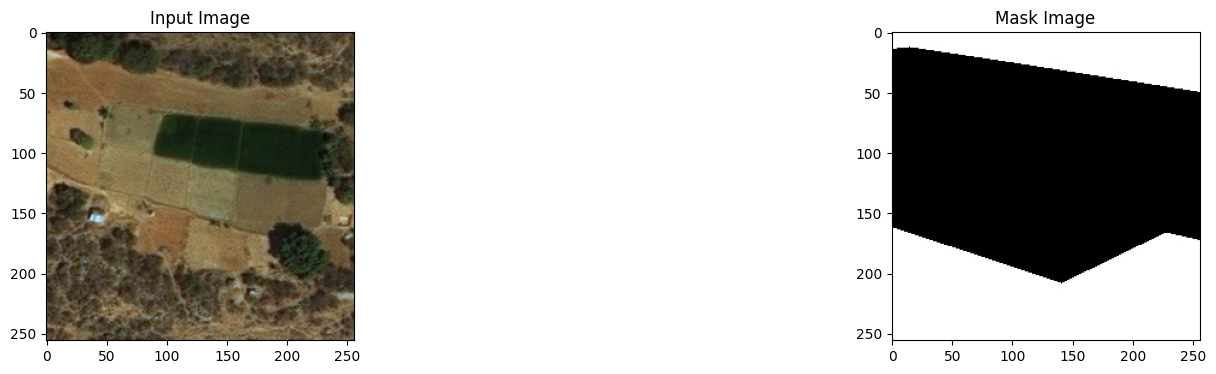

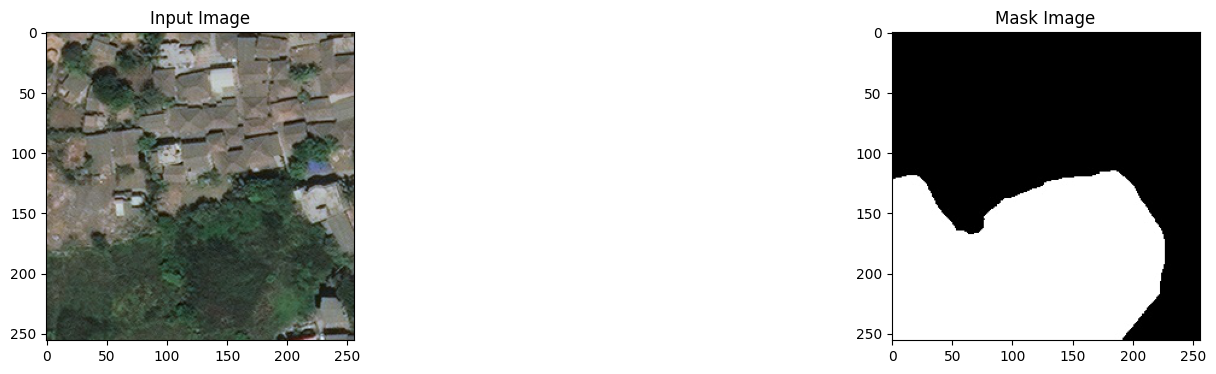

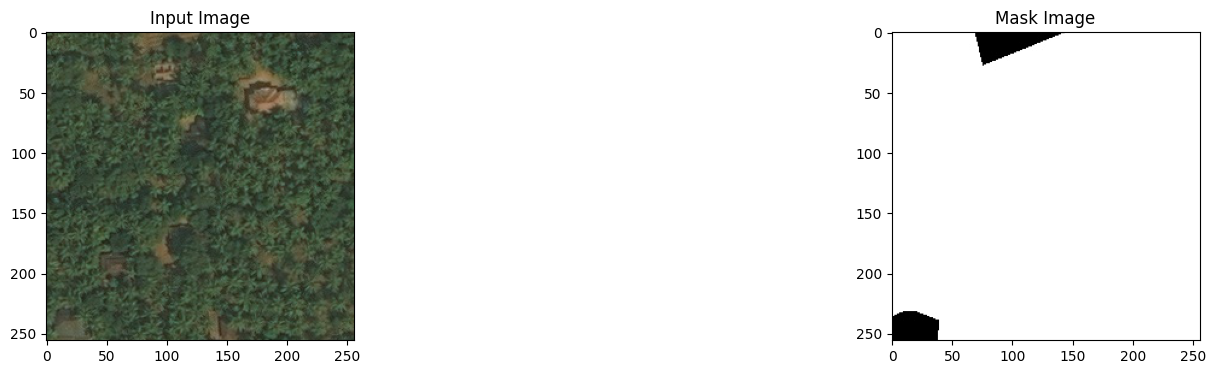

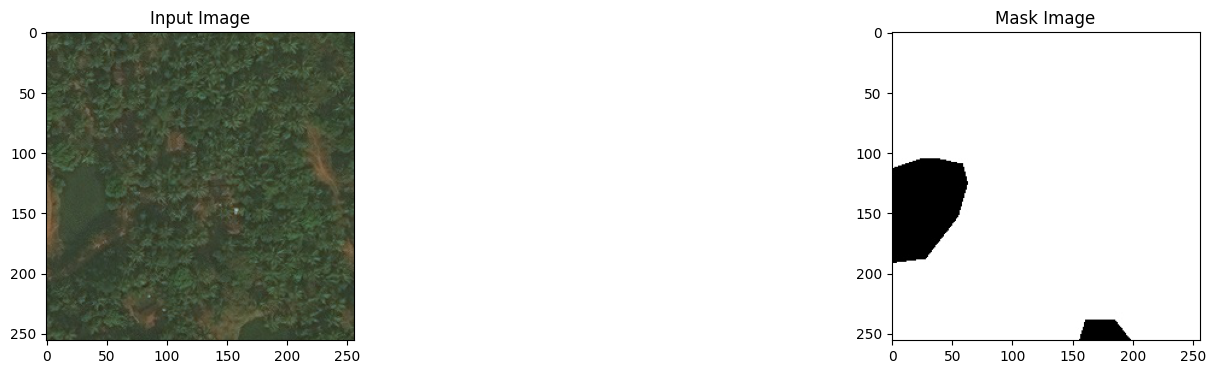

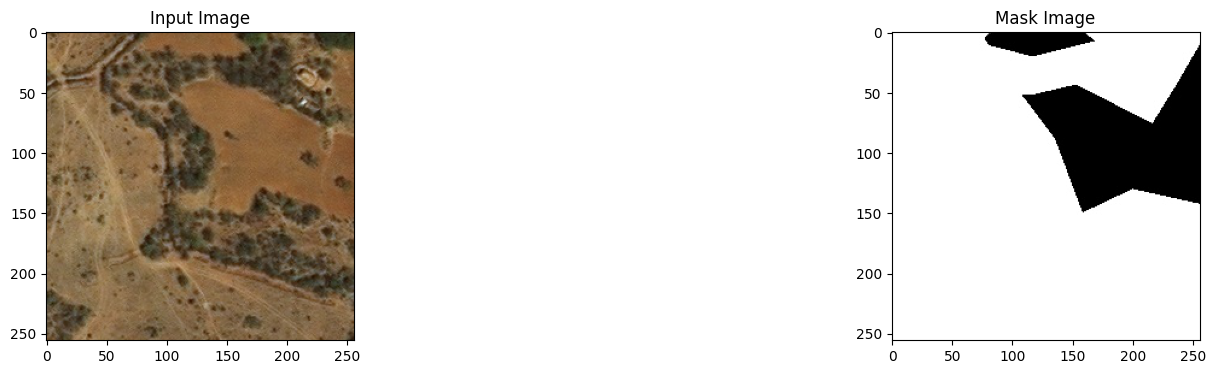

In [32]:
n = 0
for i,m in train_generator:
    img,mask = i,m

    if n < 5:
        fig, axs = plt.subplots(1 , 2, figsize=(20,4))
        axs[0].imshow(img[0])
        axs[0].set_title('Input Image')
        axs[1].imshow(mask[0],cmap='gray')
        axs[1].set_title('Mask Image')
        plt.show()
        n+=1
    else:
        break

## Unet Model

In [33]:


def build_unet(input_shape):
    def conv_block(input, num_filters):
        x = Conv2D(num_filters, 3, padding="same")(input)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(num_filters, 3, padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

        return x

    def encoder_block(input, num_filters):
        x = conv_block(input, num_filters)
        p = MaxPool2D((2, 2))(x)
        return x, p

    def decoder_block(input, skip_features, num_filters):
        x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
        x = Concatenate()([x, skip_features])
        x = conv_block(x, num_filters)
        return x

    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)

    b1 = conv_block(p4, 512)

    d1 = decoder_block(b1, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model


In [34]:
input_shape = (img_dim, img_dim, 3)
model = build_unet(input_shape)
model.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.001), loss = ['binary_crossentropy'], metrics=['accuracy'])
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_57 (Conv2D)             (None, 256, 256, 32  896         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_54 (BatchN  (None, 256, 256, 32  128        ['conv2d_57[0][0]']              
 ormalization)                  )                                                             

## Model Training

In [35]:


earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)



history = model.fit(train_generator,
                    steps_per_epoch=training_samples_size//32,
                    validation_data=val_generator,
                    validation_steps=val_samples_size//32,
                    epochs=50, callbacks=[earlystop])

Epoch 1/50
135/135 [==============================] - 54s 354ms/step - loss: 0.5592 - accuracy: 0.7247 - val_loss: 99.6630 - val_accuracy: 0.3975
Epoch 2/50
135/135 [==============================] - 47s 351ms/step - loss: 0.5199 - accuracy: 0.7559 - val_loss: 2.1873 - val_accuracy: 0.3597
Epoch 3/50
135/135 [==============================] - 48s 352ms/step - loss: 0.5173 - accuracy: 0.7529 - val_loss: 1.2753 - val_accuracy: 0.5116
Epoch 4/50
135/135 [==============================] - 51s 376ms/step - loss: 0.4886 - accuracy: 0.7711 - val_loss: 0.4415 - val_accuracy: 0.8021
Epoch 5/50
135/135 [==============================] - 48s 353ms/step - loss: 0.4952 - accuracy: 0.7703 - val_loss: 0.9443 - val_accuracy: 0.7393
Epoch 6/50
135/135 [==============================] - 48s 353ms/step - loss: 0.4788 - accuracy: 0.7734 - val_loss: 0.5278 - val_accuracy: 0.7707
Epoch 7/50
135/135 [==============================] - 48s 354ms/step - loss: 0.4873 - accuracy: 0.7691 - val_loss: 0.4221 - val_a

## Results

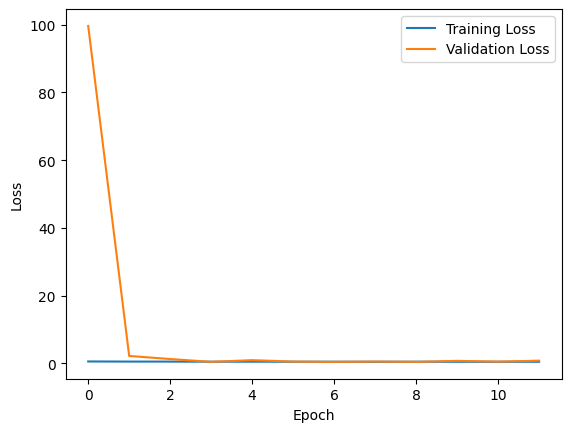

In [36]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

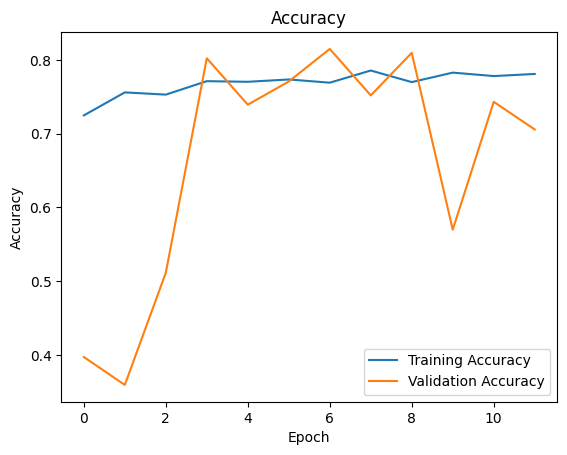

In [37]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

1/1 [==============================] - 0s 21ms/step


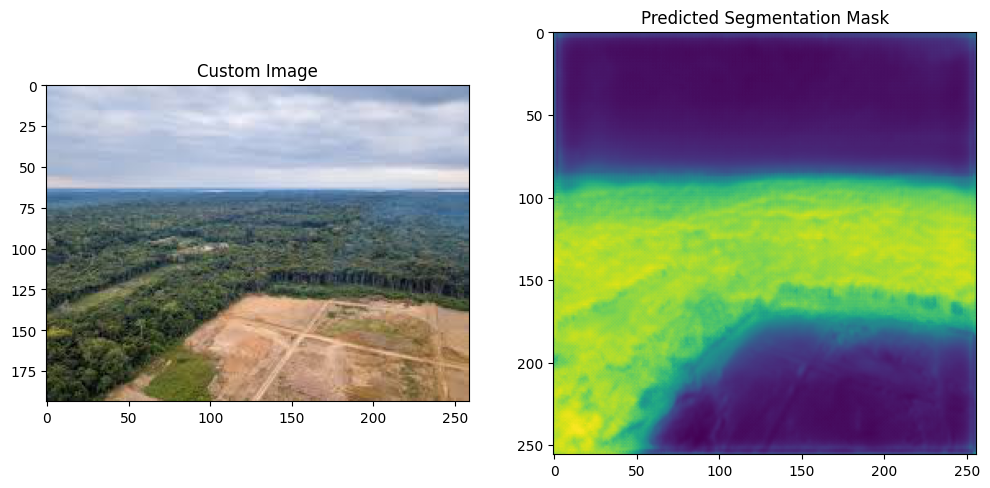

In [41]:
from skimage.io import imread
from skimage.transform import resize


# Function to predict segmentation for a custom image
def predict_segmentation(model, custom_image_path):
    custom_image = imread(custom_image_path)
    custom_image = resize(custom_image, (256, 256), preserve_range=True)  # Resize to 256x256
    custom_image = custom_image.astype('float32') / 255.0
    custom_image = np.expand_dims(custom_image, axis=0)
    predicted_mask = model.predict(custom_image)
    return predicted_mask[0]

# Path to the custom image
custom_image_path = r"C:\Users\deepchanddc2\Downloads\images.jpg"

# Predict segmentation for the custom image
predicted_mask = predict_segmentation(model, custom_image_path)

# Visualize the custom image and its predicted mask
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(imread(custom_image_path))
plt.title('Custom Image')

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask[:, :, 0], cmap='viridis')
plt.title('Predicted Segmentation Mask')

plt.show()


In [ ]:
model.save(r'D:\data science\Practice\Unet\Model')

print("Model saved successfully")